In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,\
                          UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
import keras
import tensorflow as tf
from keras import callbacks
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras import optimizers


Using TensorFlow backend.


In [2]:
tf.test.is_gpu_available

<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>

In [3]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())


In [4]:
# with tf.device('/gpu:0'):
#     a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
#     b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
#     c = tf.matmul(a, b)

# with tf.Session() as sess:
#     print (sess.run(c))

In [5]:
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [2]:
datadir = 'D:\sapienza\ML\MWI-Dataset-1.1_2000'


In [3]:
testdir = 'D:\sapienza\ML\Weather_dataset'


In [45]:
batch_size = 5
input_shape = ()
train_datagen = ImageDataGenerator(
    rescale = 1. / 250,\
    zoom_range=0.3,      # u can change image pixels, but change rescale too(divide with theri sum)
    rotation_range=10,\
    width_shift_range=0.2,\
    height_shift_range=0.2,\
    horizontal_flip=True,\
    vertical_flip=False,
    validation_split=0.2)

In [83]:
batch_size = 5
input_shape = ()
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=10,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False,
    validation_split=0.2)

In [46]:
train_generator = train_datagen.flow_from_directory(
    directory=datadir,
    target_size=(225, 225),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    subset='training',
    seed=7
)

Found 1600 images belonging to 4 classes.


In [47]:
validation_generator = train_datagen.flow_from_directory(
    directory=datadir,
    target_size=(225, 225),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False, #change it again
    subset='validation',
    seed=7
)

Found 400 images belonging to 4 classes.


In [48]:
num_samples = train_generator.n
input_shape = train_generator.image_shape
classnames = [k for k,v in train_generator.class_indices.items()]


SUNNY


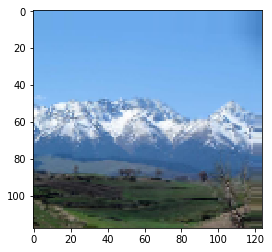

RAINY


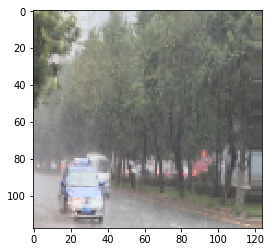

SNOWY


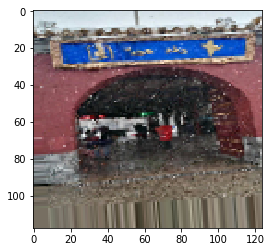

In [50]:
n = 3
x,y = train_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()

In [66]:
def RandNet(input_shape, num_classes): # do grid search on optimizer,lr,dropout
    
    model = Sequential(name="RandNet")
    
    model.add(Conv2D(16, kernel_size=(2, 2), strides=(1, 1), activation='relu', input_shape=input_shape, padding="valid"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
    model.add(BatchNormalization())

    model.add(Conv2D(32, kernel_size=(4, 4), strides=(2, 2), activation='relu', padding='valid'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
    model.add(BatchNormalization())
    
    
    model.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), activation='relu', padding='valid'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
    model.add(BatchNormalization())


   # model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid'))
   # model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='valid'))
   # model.add(BatchNormalization())


    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(num_classes, activation='softmax'))


    #optimizer = opt(lr=learning_rate) #alternative 'SGD'
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=optimizers.SGD(lr=1e-4,nesterov=True,momentum=0.9), metrics=['accuracy'])
    
    return model

In [67]:
model = RandNet(input_shape, 4)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 223, 223, 16)      0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 223, 223, 16)      64        
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 110, 110, 32)      8224      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 109, 109, 32)      0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 109, 109, 32)      128       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 53, 53, 64)        51264     
__________

In [39]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=True)

In [68]:
stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=6)
stopping2 = keras.callbacks.EarlyStopping(monitor='acc', patience=4)

steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=validation_generator.n//validation_generator.batch_size

try:
    history = model.fit_generator(train_generator, epochs=20, verbose=1, callbacks=[stopping,stopping2,checkpointer],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=validation_generator,\
                     use_multiprocessing=True,
                     workers=0,
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/20
 50/320 [===>..........................] - ETA: 51s - loss: 1.4059 - acc: 0.5160

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))


199/320 [=================>............] - ETA: 19s - loss: 1.1777 - acc: 0.5618

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1048576 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


214/320 [===================>..........] - ETA: 16s - loss: 1.1517 - acc: 0.5710

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))


319/320 [============================>.] - ETA: 0s - loss: 1.1253 - acc: 0.5806

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


320/320 [==============================] - 58s 182ms/step - loss: 1.1267 - acc: 0.5806 - val_loss: 1.8354 - val_acc: 0.4300

Epoch 00001: val_acc did not improve from 0.78000
Epoch 2/20
320/320 [==============================] - 57s 177ms/step - loss: 0.9125 - acc: 0.6575 - val_loss: 0.7598 - val_acc: 0.7200

Epoch 00002: val_acc did not improve from 0.78000
Epoch 3/20
176/320 [===============>..............] - ETA: 22s - loss: 0.9007 - acc: 0.6750

In [109]:
model.load_weights('best_weights.hdf5')


In [41]:
loss,acc = model.evaluate_generator(validation_generator,verbose=1,steps=val_steps)
print('validation loss: %f' %loss)
print('validation accuracy: %f' %acc)




80/80 [==============================] - 7s 91ms/step
validation loss: 0.569163
validation accuracy: 0.790000


In [52]:
test_datagen = ImageDataGenerator(
    rescale = 1. / 250)

test_generator = test_datagen.flow_from_directory(
    directory=testdir,
    target_size=(225, 225),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3038 images belonging to 4 classes.


In [ ]:
x,y = test_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,5):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()

In [58]:
val_steps=test_generator.n//test_generator.batch_size+1
loss, acc = model.evaluate_generator(test_generator,verbose=1,steps=val_steps, use_multiprocessing=True,workers=0)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)

608/608 [==============================] - 30s 49ms/step
Test loss: 1.196270
Test accuracy: 0.453917


In [59]:
test_generator.reset()


pred = model.predict_generator(test_generator,verbose=1,steps=val_steps)

predicted_class_indices=np.argmax(pred,axis=1)
#labels = (train_generator.class_indices)
#labels = dict((v,k) for k,v in labels.items())
#predictions = [labels[k] for k in predicted_class_indices]


#Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator


target_names = ['HAZE', 'RAINY', 'SNOWY','SUNNY']

print(classification_report(Ytest, predicted_class_indices, labels=None, target_names=target_names, digits=3))

608/608 [==============================] - 22s 37ms/step
              precision    recall  f1-score   support

        HAZE      0.000     0.000     0.000         0
       RAINY      0.184     0.157     0.170       521
       SNOWY      0.574     0.684     0.624      1421
       SUNNY      0.363     0.297     0.326      1096

   micro avg      0.454     0.454     0.454      3038
   macro avg      0.280     0.284     0.280      3038
weighted avg      0.431     0.454     0.439      3038



C:\Users\Theo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [111]:
val_steps=validation_generator.n//validation_generator.batch_size


pred = model.predict_generator(validation_generator,verbose=1,steps=val_steps)

predicted_class_indices=np.argmax(pred,axis=1)
#labels = (train_generator.class_indices)
#labels = dict((v,k) for k,v in labels.items())
#predictions = [labels[k] for k in predicted_class_indices]


#Ypred = np.argmax(preds, axis=1)
Ytest = validation_generator.classes  # shuffle=False in test_generator


target_names = ['HAZE', 'RAINY', 'SNOWY','SUNNY']

print(classification_report(Ytest, predicted_class_indices, labels=None, target_names=target_names, digits=3))

80/80 [==============================] - 5s 62ms/step
              precision    recall  f1-score   support

        HAZE      0.753     0.700     0.725       100
       RAINY      0.667     0.600     0.632       100
       SNOWY      0.571     0.600     0.585       100
       SUNNY      0.741     0.830     0.783       100

   micro avg      0.682     0.682     0.682       400
   macro avg      0.683     0.682     0.681       400
weighted avg      0.683     0.682     0.681       400



In [20]:
cm = confusion_matrix(Ytest, predicted_class_indices)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
      for j in range(0,cm.shape[1]):
            if (i!=j and cm[i][j]>0):
                  conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
      print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))
  

True                 Predicted         	errors 	err % 
------------------------------------------------------------------
SUNNY            ->  RAINY             	620 	20.41 % 
SUNNY            ->  SNOWY             	263 	8.66 % 
SNOWY            ->  RAINY             	212 	6.98 % 
SNOWY            ->  HAZE              	138 	4.54 % 
RAINY            ->  HAZE              	112 	3.69 % 
SNOWY            ->  SUNNY             	104 	3.42 % 
RAINY            ->  SNOWY             	101 	3.32 % 
SUNNY            ->  HAZE              	50 	1.65 % 
RAINY            ->  SUNNY             	15 	0.49 % 


In [21]:

def plot_history(history,name):

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

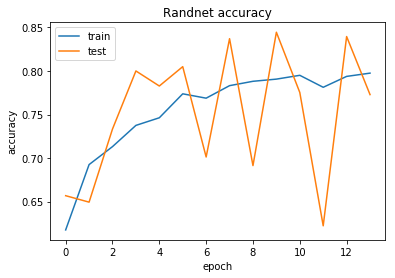

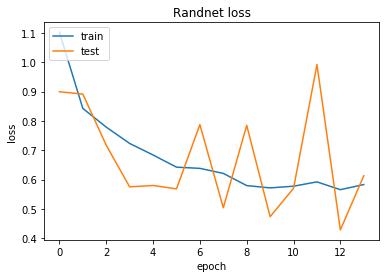

In [22]:
plot_history(history,'Randnet')

In [69]:
def cross_validate(number_of_folds):
    accuracies=[]
    losses=[]
    for i in  range(number_of_folds):
        random_state=np.random.randint(1,1000, 1)[0]
        batch_size = 5
        input_shape = ()
        train_datagen = ImageDataGenerator(
        rescale = 1. / 255,\
        zoom_range=0.1,\
        rotation_range=10,\
        width_shift_range=0.1,\
        height_shift_range=0.1,\
        horizontal_flip=True,\
        vertical_flip=False,
        validation_split=0.2,
        )

        train_generator = train_datagen.flow_from_directory(
        directory=datadir,
        target_size=(128, 224),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True,
        subset='training',
        seed=random_state
    )

        validation_generator = train_datagen.flow_from_directory(
        directory=datadir,
        target_size=(128, 224),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True,
        subset='validation',
        seed=random_state
    )

        num_samples = train_generator.n
        input_shape = train_generator.image_shape
        classnames = [k for k,v in train_generator.class_indices.items()]


        model = RandNet(input_shape, 4)


        stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=4)

        steps_per_epoch=train_generator.n//train_generator.batch_size
        val_steps=validation_generator.n//validation_generator.batch_size+1

        try:
            history = model.fit_generator(train_generator, epochs=20, verbose=1, callbacks=[stopping,checkpointer],\
                        steps_per_epoch=steps_per_epoch,\
                        validation_data=validation_generator,\
                        validation_steps=val_steps)
        except KeyboardInterrupt:
            pass
        
        loss,acc = model.evaluate_generator(validation_generator,verbose=1,steps=val_steps)
        losses.append(loss)
        accuracies.append(acc)
        #print('validation loss: %f' %loss)
        #print('validation accuracy: %f' %acc)
    return accuracies,losses

In [70]:
cross_acc,cross_loss=cross_validate(5)

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Epoch 1/20
155/320 [=============>................] - ETA: 14s - loss: 1.1810 - acc: 0.5884

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))


305/320 [===========================>..] - ETA: 1s - loss: 1.0516 - acc: 0.6210- ETA: 1s - loss: 1.0584 - acc: 0

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1048576 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))


319/320 [============================>.] - ETA: 0s - loss: 1.0514 - acc: 0.6213

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


320/320 [==============================] - 31s 97ms/step - loss: 1.0494 - acc: 0.6219 - val_loss: 0.7842 - val_acc: 0.7358

Epoch 00001: val_acc did not improve from 0.84198
Epoch 2/20
320/320 [==============================] - 29s 91ms/step - loss: 0.7733 - acc: 0.7156 - val_loss: 0.6344 - val_acc: 0.7679

Epoch 00002: val_acc did not improve from 0.84198
Epoch 3/20
320/320 [==============================] - 29s 91ms/step - loss: 0.7718 - acc: 0.7238 - val_loss: 0.6746 - val_acc: 0.7753

Epoch 00003: val_acc did not improve from 0.84198
Epoch 4/20
320/320 [==============================] - 30s 92ms/step - loss: 0.7586 - acc: 0.7113 - val_loss: 0.5425 - val_acc: 0.7753

Epoch 00004: val_acc did not improve from 0.84198
Epoch 5/20
320/320 [==============================] - 30s 95ms/step - loss: 0.7819 - acc: 0.6938 - val_loss: 0.6272 - val_acc: 0.7531

Epoch 00005: val_acc did not improve from 0.84198
Epoch 6/20
320/320 [==============================] - 32s 99ms/step - loss: 0.7018 - a

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


  5/320 [..............................] - ETA: 2:09 - loss: 2.2873 - acc: 0.4400

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))


315/320 [============================>.] - ETA: 0s - loss: 1.1061 - acc: 0.6025

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1048576 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


320/320 [==============================] - 32s 102ms/step - loss: 1.0988 - acc: 0.6056 - val_loss: 0.9036 - val_acc: 0.6815

Epoch 00001: val_acc did not improve from 0.84198
Epoch 2/20
320/320 [==============================] - 31s 97ms/step - loss: 0.8155 - acc: 0.6869 - val_loss: 0.6249 - val_acc: 0.7704

Epoch 00002: val_acc did not improve from 0.84198
Epoch 3/20
320/320 [==============================] - 32s 99ms/step - loss: 0.7804 - acc: 0.7088 - val_loss: 0.6766 - val_acc: 0.6938

Epoch 00003: val_acc did not improve from 0.84198
Epoch 4/20
320/320 [==============================] - 32s 99ms/step - loss: 0.7620 - acc: 0.7031 - val_loss: 0.6566 - val_acc: 0.7506

Epoch 00004: val_acc did not improve from 0.84198
Epoch 5/20
320/320 [==============================] - 33s 103ms/step - loss: 0.6902 - acc: 0.7475 - val_loss: 0.5772 - val_acc: 0.7852

Epoch 00005: val_acc did not improve from 0.84198
Epoch 6/20
320/320 [==============================] - 34s 107ms/step - loss: 0.6767 

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))


113/320 [=========>....................] - ETA: 19s - loss: 1.1512 - acc: 0.5681

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1048576 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


125/320 [==========>...................] - ETA: 18s - loss: 1.1528 - acc: 0.5680

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))


319/320 [============================>.] - ETA: 0s - loss: 1.0465 - acc: 0.6063

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


320/320 [==============================] - 34s 106ms/step - loss: 1.0443 - acc: 0.6075 - val_loss: 1.1305 - val_acc: 0.5877

Epoch 00001: val_acc did not improve from 0.84198
Epoch 2/20
320/320 [==============================] - 33s 102ms/step - loss: 0.8439 - acc: 0.6900 - val_loss: 0.6066 - val_acc: 0.7679

Epoch 00002: val_acc did not improve from 0.84198
Epoch 3/20
320/320 [==============================] - 31s 98ms/step - loss: 0.7651 - acc: 0.7075 - val_loss: 0.6366 - val_acc: 0.7580

Epoch 00003: val_acc did not improve from 0.84198
Epoch 4/20
320/320 [==============================] - 32s 100ms/step - loss: 0.7199 - acc: 0.7269 - val_loss: 0.9711 - val_acc: 0.6395

Epoch 00004: val_acc did not improve from 0.84198
Epoch 5/20
320/320 [==============================] - 33s 102ms/step - loss: 0.7079 - acc: 0.7300 - val_loss: 0.5294 - val_acc: 0.8074

Epoch 00005: val_acc did not improve from 0.84198
Epoch 6/20
320/320 [==============================] - 32s 99ms/step - loss: 0.7120

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


223/320 [===================>..........] - ETA: 8s - loss: 1.1484 - acc: 0.6000

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))


289/320 [==========================>...] - ETA: 2s - loss: 1.0917 - acc: 0.6194

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))


297/320 [==========================>...] - ETA: 2s - loss: 1.0868 - acc: 0.6182

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1048576 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


320/320 [==============================] - 33s 103ms/step - loss: 1.0789 - acc: 0.6194 - val_loss: 1.3853 - val_acc: 0.4864

Epoch 00001: val_acc did not improve from 0.84198
Epoch 2/20
320/320 [==============================] - 32s 100ms/step - loss: 0.9005 - acc: 0.6444 - val_loss: 0.6800 - val_acc: 0.7605

Epoch 00002: val_acc did not improve from 0.84198
Epoch 3/20
320/320 [==============================] - 33s 103ms/step - loss: 0.8013 - acc: 0.6844 - val_loss: 0.5830 - val_acc: 0.7506

Epoch 00003: val_acc did not improve from 0.84198
Epoch 4/20
320/320 [==============================] - 32s 101ms/step - loss: 0.7269 - acc: 0.7231 - val_loss: 0.5983 - val_acc: 0.7704

Epoch 00004: val_acc did not improve from 0.84198
Epoch 5/20
320/320 [==============================] - 33s 104ms/step - loss: 0.6854 - acc: 0.7475 - val_loss: 0.6363 - val_acc: 0.7383

Epoch 00005: val_acc did not improve from 0.84198
Epoch 6/20
320/320 [==============================] - 34s 105ms/step - loss: 0.64

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1048576 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


 42/320 [==>...........................] - ETA: 33s - loss: 1.6782 - acc: 0.4238 ETA: 36s - loss: 1.

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))


254/320 [======================>.......] - ETA: 6s - loss: 1.1564 - acc: 0.5858

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))


319/320 [============================>.] - ETA: 0s - loss: 1.1195 - acc: 0.5962

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


320/320 [==============================] - 37s 116ms/step - loss: 1.1181 - acc: 0.5963 - val_loss: 0.8119 - val_acc: 0.6938

Epoch 00001: val_acc did not improve from 0.84198
Epoch 2/20
320/320 [==============================] - 36s 113ms/step - loss: 0.8506 - acc: 0.6706 - val_loss: 0.5958 - val_acc: 0.7802

Epoch 00002: val_acc did not improve from 0.84198
Epoch 3/20
320/320 [==============================] - 36s 111ms/step - loss: 0.7365 - acc: 0.7100 - val_loss: 1.5632 - val_acc: 0.4864

Epoch 00003: val_acc did not improve from 0.84198
Epoch 4/20
320/320 [==============================] - 35s 109ms/step - loss: 0.7608 - acc: 0.6994 - val_loss: 0.6327 - val_acc: 0.7852

Epoch 00004: val_acc did not improve from 0.84198
Epoch 5/20
320/320 [==============================] - 34s 106ms/step - loss: 0.7150 - acc: 0.7300 - val_loss: 0.5442 - val_acc: 0.7728

Epoch 00005: val_acc did not improve from 0.84198
Epoch 6/20
320/320 [==============================] - 34s 106ms/step - loss: 0.70

In [72]:
sum(cross_acc) / len(cross_acc)

0.7091358138455284

In [73]:
import statistics

In [74]:
statistics.stdev(cross_acc)


0.11224931319185727

In [75]:
cross_acc

[0.7481481592964243,
 0.7580247024695078,
 0.676543222349367,
 0.5333333458797431,
 0.8296296392326001]